### Testing Temp -> Demand conversion ###

Based on Hannah Bloomfield's S2S4E scripts, converting the NUTS0 aggregated temperature data into national demand (for ERA5 first).

Before moving onto explore how we might go about doing this conversion for the decadal predictions at daily timescales (e.g HadGEM3-GC31-MM in the first instance).

In [1]:
# cell magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
! pip install regionmask

Defaulting to user installation because normal site-packages is not writeable


In [3]:
! pip install ncdata

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Import the functions
sys.path.append("/home/users/benhutch/unseen_functions")

import functions_demand as func_dm

import bias_functions as bias_func

import load_wind_functions as lw_func

In [5]:
# import dictionaries
sys.path.append("/home/users/benhutch/unseen_functions")

import unseen_dictionaries as udicts

In [6]:
# set up the global variables
# set up for a single country
first_year = 1960
last_year = 1960
first_month = 1
last_month = 1
init_years = np.arange(1960, 2018 + 1, 1)
variable = "tas"
lead_time = 1
obs_variable = "t2m"
country = "United Kingdom"
country_name = "United_Kingdom"

# set up the path to the observations (daily, temperature)
obs_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_t2m_daily_1950_2020.nc"

# set up the path to the model data (daily, temperature)
model_path = "/work/scratch-nopw2/benhutch/test_nc/tas_bias_correction_HadGEM3-GC31-MM_lead1_month11_init1960-1960.nc"

# model path month 2
model_path2 = "/work/scratch-nopw2/benhutch/test_nc/tas_bias_correction_HadGEM3-GC31-MM_lead1_month12_init1960-1960.nc"

# Test ds
test_file_path = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc"

In [7]:
# set up the path to the file
dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

fname = "wd_demand_HadGEM3-GC31-MM_months_11-10_lead1_init_1960-2018_United Kingdom.csv"

In [8]:
# load the dataframe
df = pd.read_csv(os.path.join(dir, fname))

In [9]:
# print the head of the df
print(df.head())

   init    member  lead  United_Kingdom_tas  United_Kingdom_hdd  \
0  1960  r7i1p1f2     1            8.942216            6.557784   
1  1960  r7i1p1f2     2            7.611440            7.888560   
2  1960  r7i1p1f2     3            8.075678            7.424322   
3  1960  r7i1p1f2     4            7.372388            8.127612   
4  1960  r7i1p1f2     5            6.361683            9.138317   

   United_Kingdom_cdd  United_Kingdom_demand  
0                 0.0              39.958743  
1                 0.0              40.953643  
2                 0.0              40.606574  
3                 0.0              41.132360  
4                 0.0              41.887972  


In [10]:
# print the shape of the df
print(df.shape)

(212400, 7)


In [11]:
# print the unique leads
print(df["lead"].unique())


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [12]:
# print the unique ensemble members
print(df["member"].unique())

['r7i1p1f2' 'r1i1p1f2' 'r6i1p1f2' 'r2i1p1f2' 'r4i1p1f2' 'r9i1p1f2'
 'r10i1p1f2' 'r3i1p1f2' 'r5i1p1f2' 'r8i1p1f2']


In [13]:
# print the unique inits
print(df["init"].unique())

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018]


In [14]:
%%time

# Load the file
model_ds = xr.open_dataset(test_file_path)

# Load the observations
# But first regrid
obs = bias_func.load_and_rg_obs(
    model_ds=model_ds,
    obs_variable=obs_variable,
    obs_path=obs_path,
    init_years=init_years,
    lead_time=lead_time,
    rg_algo="bilinear",
    grid_bounds=[-180.0, 180.0, -90.0, 90.0],
    periodic=True,
    parallel=False,
)

# Select the gridbox
obs = bias_func.select_gridbox(
    ds=obs,
    grid=udicts.eu_grid_constrained,
    calc_mean=False,
)

CPU times: user 4.07 s, sys: 55.9 ms, total: 4.13 s
Wall time: 5.52 s


In [ ]:
# # Check out the observations
# obs

In [15]:
importlib.reload(lw_func)

<module 'load_wind_functions' from '/home/users/benhutch/unseen_functions/load_wind_functions.py'>

In [16]:
# Apply the country mask to the obs data
obs = lw_func.apply_country_mask(
    ds=obs,
    country=country,
    lon_name="lon",
    lat_name="lat",
)

Found the country!
Pre-country mask
<xarray.DataArray (y: 324, x: 432)>
dask.array<getitem, shape=(324, 432), dtype=float32, chunksize=(324, 432), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1960-11-01
    lon      (x) float64 -179.6 -178.8 -177.9 -177.1 ... 177.1 177.9 178.7 179.6
    lat      (y) float64 -89.72 -89.17 -88.61 -88.06 ... 88.06 88.61 89.17 89.72
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear
[-179.58333336 -178.75000007 -177.91666678 -177.0833335  -176.25000021
 -175.41666693 -174.58333364 -173.75000035 -172.91666707 -172.08333378
 -171.2500005  -170.41666721 -169.58333392 -168.75000064 -167.91666735
 -167.08333406 -166.25000078 -165.41666749 -164.58333421 -163.75000092
 -162.91666763 -162.08333435 -161.25000106 -160.41666778 -159.58333449
 -158.7500012  -157.91666792 -157.08333463 -156.25000134 -155.41666806
 -154.58333477 -153.75000149 -152.9166682  -152.08333491 -151.25000163
 -150.41666834 -149.58333506 -148.75000

In [17]:
importlib.reload(func_dm)

<module 'functions_demand' from '/home/users/benhutch/unseen_functions/functions_demand.py'>

In [18]:
# Calculate the mean for the country
obs = func_dm.calc_spatial_mean(
    ds=obs,
    country=country_name,
    variable=obs_variable,
    convert_kelv_to_cel=True,
)
    

Processing observed data


In [19]:
# Calculate HDD and CDD
obs_df = func_dm.calc_hdd_cdd(
    df=obs,
    temp_suffix=obs_variable,
)

lead not in columns, processing observed data
Resampling to daily


In [20]:
# Calculate the national wd_demand
obs_df = func_dm.calc_national_wd_demand(
    df=obs_df,
)

Processing observed data


In [21]:
obs_df

,United_Kingdom_t2m_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960-11-01,9.970184,5.529816,0.0,39.190225
1960-11-02,8.484436,7.015564,0.0,40.300983
1960-11-03,6.850250,8.649750,0.0,41.522715
1960-11-04,7.034576,8.465424,0.0,41.384911
1960-11-05,7.439514,8.060486,0.0,41.082176
...,...,...,...,...
2019-10-26,7.718506,7.781494,0.0,40.873599
2019-10-27,6.634918,8.865082,0.0,41.683699
2019-10-28,4.910553,10.589447,0.0,42.972849
2019-10-29,5.903778,9.596222,0.0,42.230306


Observations successfully processed, can we do the same for the model data?

In [22]:
importlib.reload(lw_func)

<module 'load_wind_functions' from '/home/users/benhutch/unseen_functions/load_wind_functions.py'>

In [23]:
# loop over the monhts
months_list = [11, 12]

# set up the base_dir
base_dir = "/work/scratch-nopw2/benhutch/test_nc/"

variable_saved = "__xarray_dataarray_variable__"

# Set up an empty dataframe
combined_df = pd.DataFrame()

# loop over the months
for month_idx in tqdm(months_list):
    # Set up the fname
    fname_month = f"tas_bias_correction_HadGEM3-GC31-MM_lead1_month{month_idx}_init1960-1960.nc"

    # Set up the path
    path_month = os.path.join(base_dir, fname_month)

    # Apply the country mask
    model_month = lw_func.apply_country_mask(
        ds=xr.open_dataset(path_month),
        country=country,
        lon_name="lon",
        lat_name="lat",
    )

    # Calculate the mean for the country
    model_month = func_dm.calc_spatial_mean(
        ds=model_month,
        country=country_name,
        variable=variable_saved,
        variable_name=variable,
        convert_kelv_to_cel=True,
    )

    # combine the dataframes
    combined_df = pd.concat([combined_df, model_month], ignore_index=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Found the country!
Pre-country mask
<xarray.Dataset>
Dimensions:                        (lat: 324, lon: 432)
Coordinates:
    lead                           int64 1
    init                           int64 1960
    member                         <U8 'r4i1p1f2'
  * lat                            (lat) float64 -89.72 -89.17 ... 89.17 89.72
  * lon                            (lon) float64 -179.6 -178.8 ... 178.7 179.6
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 ...
[-179.58333336 -178.75000007 -177.91666678 -177.0833335  -176.25000021
 -175.41666693 -174.58333364 -173.75000035 -172.91666707 -172.08333378
 -171.2500005  -170.41666721 -169.58333392 -168.75000064 -167.91666735
 -167.08333406 -166.25000078 -165.41666749 -164.58333421 -163.75000092
 -162.91666763 -162.08333435 -161.25000106 -160.41666778 -159.58333449
 -158.7500012  -157.91666792 -157.08333463 -156.25000134 -155.41666806
 -154.58333477 -153.75000149 -152.9166682  -152.08333491 -151.25000163
 -150.4166

 50%|█████     | 1/2 [00:01<00:01,  1.81s/it]

Found the country!
Pre-country mask
<xarray.Dataset>
Dimensions:                        (lat: 324, lon: 432)
Coordinates:
    lead                           int64 31
    init                           int64 1960
    member                         <U8 'r6i1p1f2'
  * lat                            (lat) float64 -89.72 -89.17 ... 89.17 89.72
  * lon                            (lon) float64 -179.6 -178.8 ... 178.7 179.6
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 ...
[-179.58333336 -178.75000007 -177.91666678 -177.0833335  -176.25000021
 -175.41666693 -174.58333364 -173.75000035 -172.91666707 -172.08333378
 -171.2500005  -170.41666721 -169.58333392 -168.75000064 -167.91666735
 -167.08333406 -166.25000078 -165.41666749 -164.58333421 -163.75000092
 -162.91666763 -162.08333435 -161.25000106 -160.41666778 -159.58333449
 -158.7500012  -157.91666792 -157.08333463 -156.25000134 -155.41666806
 -154.58333477 -153.75000149 -152.9166682  -152.08333491 -151.25000163
 -150.416

100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


In [24]:
combined_df

,init,member,lead,United_Kingdom_tas
0,1960,r4i1p1f2,1,8.430088
1,1960,r4i1p1f2,2,7.253621
2,1960,r4i1p1f2,3,7.626151
3,1960,r4i1p1f2,4,6.908257
4,1960,r4i1p1f2,5,5.973406
...,...,...,...,...
595,1960,r9i1p1f2,56,4.704867
596,1960,r9i1p1f2,57,4.481637
597,1960,r9i1p1f2,58,4.708688
598,1960,r9i1p1f2,59,3.157147


In [25]:
# Calculate the heating degree days and cooling degree days
model_df = func_dm.calc_hdd_cdd(
    df=combined_df,
    country_name=country_name,
    variable_name=variable,
)

Model data already in daily format.


In [26]:
# Calculate the weather dependent demand
model_df = func_dm.calc_national_wd_demand(
    df=model_df,
    country_name=country_name,
)

Processing model data


In [27]:
model_df

,init,member,lead,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960,r4i1p1f2,1,8.430088,7.069912,0,40.341615
1,1960,r4i1p1f2,2,7.253621,8.246379,0,41.221151
2,1960,r4i1p1f2,3,7.626151,7.873849,0,40.942645
3,1960,r4i1p1f2,4,6.908257,8.591743,0,41.479349
4,1960,r4i1p1f2,5,5.973406,9.526594,0,42.178251
...,...,...,...,...,...,...,...
595,1960,r9i1p1f2,56,4.704867,10.795133,0,43.126622
596,1960,r9i1p1f2,57,4.481637,11.018363,0,43.293510
597,1960,r9i1p1f2,58,4.708688,10.791312,0,43.123765
598,1960,r9i1p1f2,59,3.157147,12.342853,0,44.283711


In [28]:
# set up the fname for the fike
fname = f"wd_demand_{country_name}_month11-12_init1960-1960.csv"

# save the df
func_dm.save_df(
    df=model_df,
    fname=fname,
)

FileExistsError: File wd_demand_United_Kingdom_month11-12_init1960-1960.csv already exists in /gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs

In [29]:
# Test loading the file
dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

fname = "wd_demand_United_Kingdom_month11-12_init1960-1960.csv.csv"

# Load the file
df = pd.read_csv(os.path.join(dir, fname))

In [30]:
df

,Unnamed: 0,init,member,lead,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,0,1960,r4i1p1f2,1,8.430088,7.069912,0,40.341615
1,1,1960,r4i1p1f2,2,7.253621,8.246379,0,41.221151
2,2,1960,r4i1p1f2,3,7.626151,7.873849,0,40.942645
3,3,1960,r4i1p1f2,4,6.908257,8.591743,0,41.479349
4,4,1960,r4i1p1f2,5,5.973406,9.526594,0,42.178251
...,...,...,...,...,...,...,...,...
595,595,1960,r9i1p1f2,56,4.704867,10.795133,0,43.126622
596,596,1960,r9i1p1f2,57,4.481637,11.018363,0,43.293510
597,597,1960,r9i1p1f2,58,4.708688,10.791312,0,43.123765
598,598,1960,r9i1p1f2,59,3.157147,12.342853,0,44.283711


In [32]:
# Apply the country mask to the model data
model = lw_func.apply_country_mask(
    ds=model,
    country=country,
    lon_name="lon",
    lat_name="lat",
)

model_2 = lw_func.apply_country_mask(
    ds=model_2,
    country=country,
    lon_name="lon",
    lat_name="lat",
)

NameError: name 'model' is not defined

In [ ]:
importlib.reload(func_dm)

In [ ]:
# Calculate the spatial mean for the country
model_df = func_dm.calc_spatial_mean(
    ds=model,
    country=country_name,
    variable="__xarray_dataarray_variable__",
    variable_name=variable,
    convert_kelv_to_cel=True,
)

model_df_2 = func_dm.calc_spatial_mean(
    ds=model_2,
    country=country_name,
    variable="__xarray_dataarray_variable__",
    variable_name=variable,
    convert_kelv_to_cel=True,
)

In [ ]:
model_df

In [ ]:
model_df_2

In [ ]:
combined_model_df = pd.concat([model_df, model_df_2], ignore_index=True)

In [ ]:
combined_model_df

In [ ]:
# Calculate the heating degree days and cooling degree days
model_df = func_dm.calc_hdd_cdd(
    df=combined_model_df,
    country_name=country_name,
    variable_name=variable,
)

In [ ]:
model_df

In [ ]:
importlib.reload(func_dm)

In [ ]:
# Calculate the weather dependent demand
model_df = func_dm.calc_national_wd_demand(
    df=model_df,
    country_name=country_name,
)

In [33]:
model_df

,init,member,lead,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960,r4i1p1f2,1,8.430088,7.069912,0,40.341615
1,1960,r4i1p1f2,2,7.253621,8.246379,0,41.221151
2,1960,r4i1p1f2,3,7.626151,7.873849,0,40.942645
3,1960,r4i1p1f2,4,6.908257,8.591743,0,41.479349
4,1960,r4i1p1f2,5,5.973406,9.526594,0,42.178251
...,...,...,...,...,...,...,...
595,1960,r9i1p1f2,56,4.704867,10.795133,0,43.126622
596,1960,r9i1p1f2,57,4.481637,11.018363,0,43.293510
597,1960,r9i1p1f2,58,4.708688,10.791312,0,43.123765
598,1960,r9i1p1f2,59,3.157147,12.342853,0,44.283711


/tmp/ipykernel_18753/549245619.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  model_df_grouped.quantile(0.05).United_Kingdom_demand,
/tmp/ipykernel_18753/549245619.py:17: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  model_df_grouped.quantile(0.95).United_Kingdom_demand,
/tmp/ipykernel_18753/549245619.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df_month["lead"] = np.arange(1, len(obs_

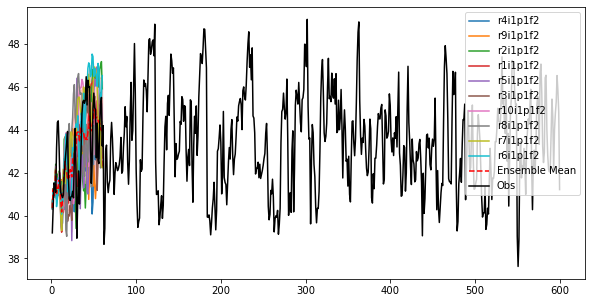

In [32]:
# plot the UK demand
# with lead on the x-axis
# United_Kingdom_demand on the y-axis
# and plot all of the members
fig, ax = plt.subplots(figsize=(10, 5))

# extract hthe unique members
unique_members = model_df.member.unique()


model_df_grouped = model_df.groupby("lead")

# include the 5-95% range
ax.fill_between(
    model_df_grouped.mean().index,
    model_df_grouped.quantile(0.05).United_Kingdom_demand,
    model_df_grouped.quantile(0.95).United_Kingdom_demand,
    alpha=0.2,
    color="red",
)


for member in unique_members:
    temp_df = model_df[model_df.member == member]
    ax.plot(temp_df.lead, temp_df.United_Kingdom_demand, label=member)


# include an ensemble mean
ensemble_mean = model_df.groupby("lead").mean()

ax.plot(ensemble_mean.index, ensemble_mean.United_Kingdom_demand, label="Ensemble Mean", color="red", linestyle="--")


# # subset the obs to the month 11 and 12
obs_df_month = obs_df[obs_df.index.month.isin([11, 12])]

# set up a new axis for lead (the time axis as 1 to len of the obs_df_month)
obs_df_month["lead"] = np.arange(1, len(obs_df_month) + 1)

# limit the obs_df_month to the same length as the model_df
obs_df_month = obs_df_month.iloc[:len(model_df)]

# plot the obs
ax.plot(obs_df_month.lead, obs_df_month.United_Kingdom_demand, label="Obs", color="black")

# include a legend
ax.legend()